In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import merge
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten,Dropout,Input,BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [0]:
token = '/content/drive/My Drive/Flickr8k_text/Flickr8k.token.txt'

In [0]:
captions = open(token, 'r').read().strip().split('\n')

In [0]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [0]:
images = '/content/drive/My Drive/images/'

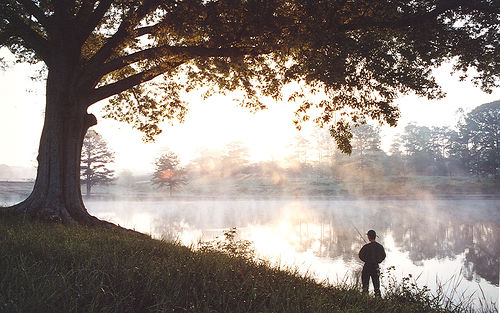

In [8]:
Image.open('/content/drive/My Drive/images/17273391_55cfc7d3d4.jpg')

In [9]:
d['17273391_55cfc7d3d4.jpg']

['A fisherman fishes at the bank of a foggy river .',
 'A man fishes by a tree in the morning mist .',
 'A man fishes under a large tree .',
 'A man fishing near a large tree .',
 'A man is fishing in a foggy lake .']

In [0]:
#images = '/content/drive/My Drive/images/'

In [0]:
img = glob.glob(images+'*.jpg')

In [12]:
img[:5]

['/content/drive/My Drive/images/10815824_2997e03d76.jpg',
 '/content/drive/My Drive/images/12830823_87d2654e31.jpg',
 '/content/drive/My Drive/images/17273391_55cfc7d3d4.jpg',
 '/content/drive/My Drive/images/55473406_1d2271c1f2.jpg',
 '/content/drive/My Drive/images/27782020_4dab210360.jpg']

In [0]:
train_images_file = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt'

In [0]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [0]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [16]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

24

In [0]:
val_images_file = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [18]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

2

In [0]:
test_images_file = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [20]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

4

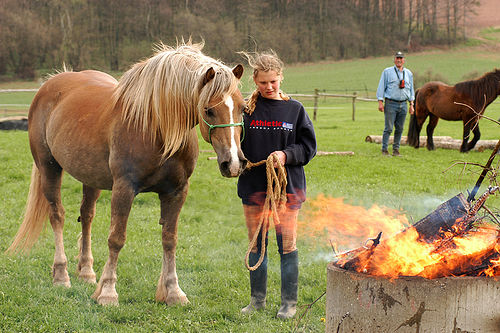

In [21]:
Image.open(train_img[0])

In [0]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


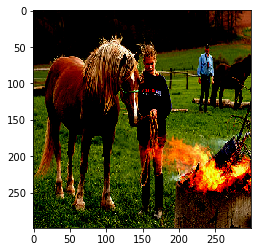

In [24]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [25]:
model = InceptionV3(weights='imagenet')














96116736/96112376 [==============================] - 8s 0us/step


In [0]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [0]:
tryi = model_new.predict(preprocess(train_img[0]))

In [28]:
tryi.shape

(1, 2048)

In [0]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [30]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 24/24 [00:10<00:00,  2.10it/s]


In [0]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [0]:

encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [33]:
encoding_train['10815824_2997e03d76.jpg'].shape

(2048,)

In [34]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


In [0]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [0]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [37]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [0]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [39]:
len(train_d)

24

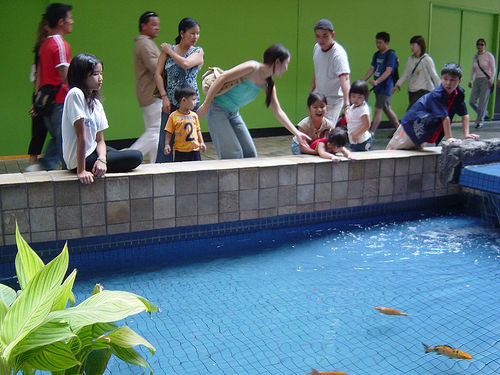

In [40]:
Image.open('/content/drive/My Drive/images/12830823_87d2654e31.jpg')

In [41]:
train_d[images+'12830823_87d2654e31.jpg']

['Children sit and watch the fish moving in the pond',
 'people stare at the orange fish .',
 'Several people are standing near a fish pond .',
 'Some children watching fish in a pool .',
 'There are several people and children looking into water with a blue tiled floor and goldfish .']

In [0]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [43]:
len(val_d)

2

In [0]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [45]:
len(test_d)

4

**Calculating the unique words in the vocabulary.**

In [0]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')


In [0]:
words = [i.split() for i in caps]

In [0]:
unique = []
for i in words:
    unique.extend(i)

In [0]:
unique = list(set(unique))

In [0]:
unique = pickle.load(open('/content/drive/My Drive/unique.p', 'rb'))

In [51]:
len(unique)

8256

In [0]:
word2idx = {val:index for index, val in enumerate(unique)}

In [53]:
word2idx['<start>']

5553

In [0]:
idx2word = {index:val for index, val in enumerate(unique)}

In [55]:
idx2word[5553]

'<start>'

**Calculating the maximum length among all the captions**

In [56]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

25

In [57]:
len(unique), max_len

(8256, 25)

In [0]:
vocab_size = len(unique)

In [59]:
vocab_size

8256

In [60]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [0]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [0]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [63]:
len(df)

120

In [64]:
c = [i for i in df['captions']]
len(c)

120

In [0]:
imgs = [i for i in df['image_id']]

In [66]:
a = c[-1]
a, imgs[-1]

('<start> A mountaineer in a yellow jacket is drinking from a thermos cup . <end>',
 '55470226_52ff517151.jpg')

In [67]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5553
A => 4228
mountaineer => 1886
in => 8156
a => 32
yellow => 7726
jacket => 7841
is => 5279
drinking => 8058
from => 720
a => 32
thermos => 7762
cup => 1447
. => 7023
<end> => 5232


In [0]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [69]:
samples_per_epoch

1594

In [0]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

**Models**

In [0]:
embedding_size = 300

In [72]:
from keras.layers import add
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [73]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])



In [74]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      2476800     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [75]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  




Epoch 1/1
 - 104s - loss: 0.9528 - acc: 0.7261


In [76]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 102s - loss: 0.1495 - acc: 0.9235


In [77]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 102s - loss: 0.1395 - acc: 0.9274


In [78]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 102s - loss: 0.1379 - acc: 0.9284


In [79]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 101s - loss: 0.1377 - acc: 0.9316


In [80]:
model.optimizer.lr = 1e-4
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  This is separate from the ipykernel package so we can avoid doing imports until


 - 102s - loss: 0.1364 - acc: 0.9314


In [81]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 102s - loss: 0.1372 - acc: 0.9313


In [0]:
model.save_weights('time_inceptionV3_7_loss_3.2604.h5')

In [0]:
model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

In [84]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


Epoch 1/1
 - 101s - loss: 0.1367 - acc: 0.9314


In [85]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 101s - loss: 0.1363 - acc: 0.9312


In [0]:
model.save_weights('time_inceptionV3_3.21_loss.h5')

In [87]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 101s - loss: 0.1369 - acc: 0.9318


In [88]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 101s - loss: 0.1369 - acc: 0.9327


In [89]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 102s - loss: 0.1363 - acc: 0.9322


In [0]:
model.save_weights('time_inceptionV3_3.15_loss.h5')

In [91]:
model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=1594, epochs=1)`
  


 - 101s - loss: 0.1376 - acc: 0.9327


**Testing Images**

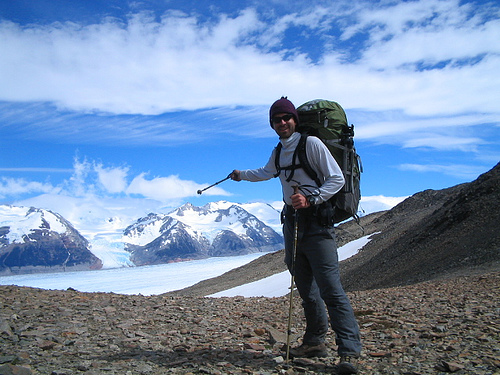

In [92]:
try_image = test_img[0]
Image.open(try_image)

In [93]:
test_d[images+'54501196_a9ac9d66f2.jpg']

['A backpacker in the mountains using his hiking stick to point at a glacier .',
 'A backpacker points to the snow-capped mountains as he stands on a rocky plain .',
 'A hiker is pointing towards the mountains .',
 'A hiker poses for a picture in front of stunning mountains and clouds .',
 'A man with a green pack using his pole to point to snowcapped mountains .']

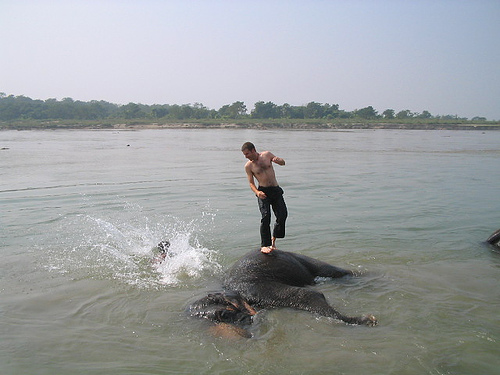

In [94]:
try_image2 = test_img[1]
Image.open(try_image2)

In [95]:
test_d[images+'53043785_c468d6f931.jpg']

['A man is standing on an animal in the water .',
 'A man is standing on an elephant lying in some water .',
 'A man standing on a rock in a river with a spash next to him .',
 'A man stands on top of an elephant in the water .',
 'A man stands on top of a submerged elephant .']

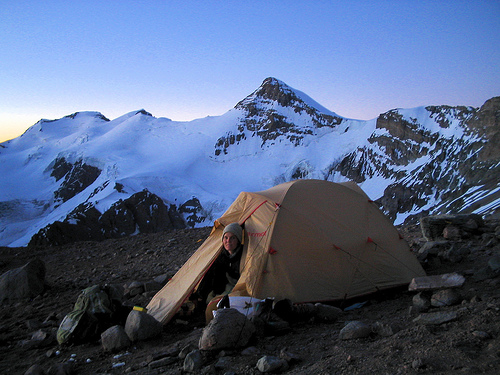

In [96]:
try_image3 = test_img[2]
Image.open(try_image3)

In [97]:
test_d[images+'57422853_b5f6366081.jpg']

['A hiker in a tent on a mountain .',
 'A hiker pokes his head out of a tent high in the mountains .',
 'A man sits in his tent on a mountain .',
 'A person sticks their head out of a tent at the top of a mountain .',
 'Someone is peaking out of a dome tent pitched near a snowy mountain .']

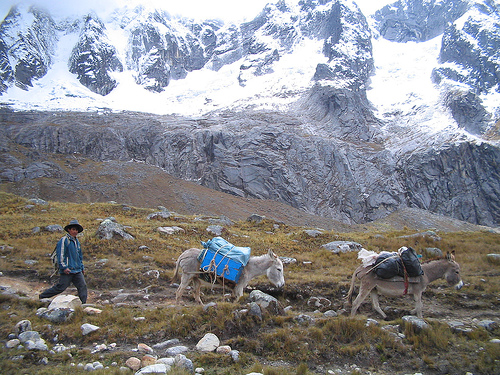

In [98]:
try_image4 = test_img[3]
Image.open(try_image4)

In [99]:
test_d[images+'56489627_e1de43de34.jpg']

['A boy is leading donkeys on a path .',
 'A man and two pack mules walk across a field in front of a mountain .',
 'A man is walking in a field behind two donkeys .',
 'A man travels with two donkeys in the mountains',
 'A person in a blue jacket follows two donkeys along a mountain trail .']